In [153]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

# from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import LSTM

#from tensorflow.python.keras.layers import CuDNNLSTM
#from tensorflow.keras.models import Sequential

In [154]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [155]:
url_binance_bnbusdt_5m = "https://api.binance.com/api/v3/klines?symbol=BNBUSDT&limit=1000&interval=5m"
df = pd.read_json(url_binance_bnbusdt_5m)

df.columns = [
    'time', 
    'open', 
    'high', 
    'low', 
    'close', 
    'volume', 
    'close_time', 
    'quote_asset_volume', 
    'number_of_trades', 
    'taker_buy_base_asset_volume', 
    'taker_buy_quote_asset_volume', 
    'unused'
]

df['date'] = pd.to_datetime(df['time'], unit='ms')

df.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused,date
0,1666516200000,270.2,270.3,270.2,270.2,204.918,1666516499999,55375.1224,250,62.788,16971.5964,0,2022-10-23 09:10:00
1,1666516500000,270.3,270.3,270.0,270.0,452.243,1666516799999,122162.1086,313,126.921,34287.9672,0,2022-10-23 09:15:00
2,1666516800000,270.1,270.1,269.9,269.9,240.463,1666517099999,64933.1210,342,89.394,24145.2163,0,2022-10-23 09:20:00
3,1666517100000,269.9,270.0,269.9,269.9,115.593,1666517399999,31205.0713,199,65.206,17605.6200,0,2022-10-23 09:25:00
4,1666517400000,270.0,270.2,269.9,270.2,525.467,1666517699999,141900.6458,272,490.196,132379.7428,0,2022-10-23 09:30:00


In [156]:
df.sort_values('time', inplace=True)

In [157]:
df.head()

,time,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,unused,date
0,1666516200000,270.2,270.3,270.2,270.2,204.918,1666516499999,55375.1224,250,62.788,16971.5964,0,2022-10-23 09:10:00
1,1666516500000,270.3,270.3,270.0,270.0,452.243,1666516799999,122162.1086,313,126.921,34287.9672,0,2022-10-23 09:15:00
2,1666516800000,270.1,270.1,269.9,269.9,240.463,1666517099999,64933.1210,342,89.394,24145.2163,0,2022-10-23 09:20:00
3,1666517100000,269.9,270.0,269.9,269.9,115.593,1666517399999,31205.0713,199,65.206,17605.6200,0,2022-10-23 09:25:00
4,1666517400000,270.0,270.2,269.9,270.2,525.467,1666517699999,141900.6458,272,490.196,132379.7428,0,2022-10-23 09:30:00


Text(0, 0.5, 'Close Price')

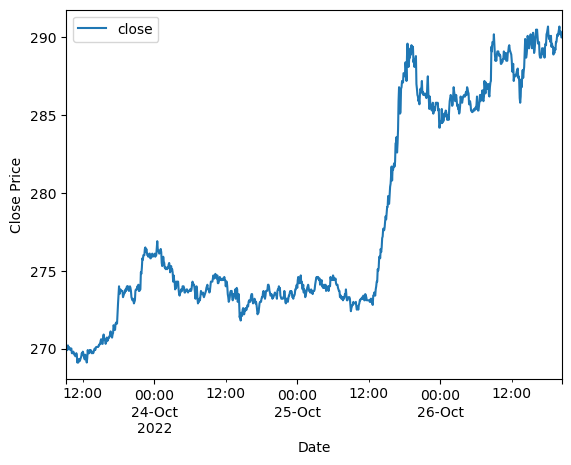

In [158]:
ax = df.plot(x='date', y='close');
ax.set_xlabel("Date")
ax.set_ylabel("Close Price")

## Normalization

In [159]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [160]:
scaled_close.shape

(1000, 1)

In [161]:
np.isnan(scaled_close).any()

False

In [162]:
scaled_close[:10], close_price[:10]

(array([[0.05092593],
        [0.04166667],
        [0.03703704],
        [0.03703704],
        [0.05092593],
        [0.04166667],
        [0.0462963 ],
        [0.04166667],
        [0.04166667],
        [0.03703704]]),
 array([[270.2],
        [270. ],
        [269.9],
        [269.9],
        [270.2],
        [270. ],
        [270.1],
        [270. ],
        [270. ],
        [269.9]]))

In [163]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [164]:
scaled_close = scaled_close.reshape(-1, 1)

In [165]:
np.isnan(scaled_close).any()

False

## Preprocessing

In [194]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.70)

In [195]:
X_train.shape

(630, 99, 1)

In [196]:
X_test.shape

(270, 99, 1)

## Model

In [197]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = keras.Sequential()

model.add(tf.keras.layers.Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

## Training

In [198]:
model.compile(
    loss='mean_squared_error', 
    # optimizer='adam'
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)
)

In [199]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
9/9 [==============================] - 7s 410ms/step - loss: 0.0234 - val_loss: 0.1838
Epoch 2/50
9/9 [==============================] - 3s 297ms/step - loss: 0.0053 - val_loss: 0.0800
Epoch 3/50
9/9 [==============================] - 3s 300ms/step - loss: 0.0012 - val_loss: 0.0095
Epoch 4/50
9/9 [==============================] - 3s 289ms/step - loss: 0.0017 - val_loss: 0.0078
Epoch 5/50
9/9 [==============================] - 3s 291ms/step - loss: 7.6299e-04 - val_loss: 0.0087
Epoch 6/50
9/9 [==============================] - 3s 289ms/step - loss: 8.2506e-04 - val_loss: 0.0116
Epoch 7/50
9/9 [==============================] - 3s 290ms/step - loss: 0.0014 - val_loss: 0.0033
Epoch 8/50
9/9 [==============================] - 3s 289ms/step - loss: 0.0012 - val_loss: 0.0030
Epoch 9/50
9/9 [==============================] - 3s 296ms/step - loss: 5.0308e-04 - val_loss: 0.0169
Epoch 10/50
9/9 [==============================] - 3s 288ms/step - loss: 7.0805e-04 - val_loss: 0.0097
Epo

In [200]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 1s 63ms/step - loss: 0.0028


0.0028336166869848967

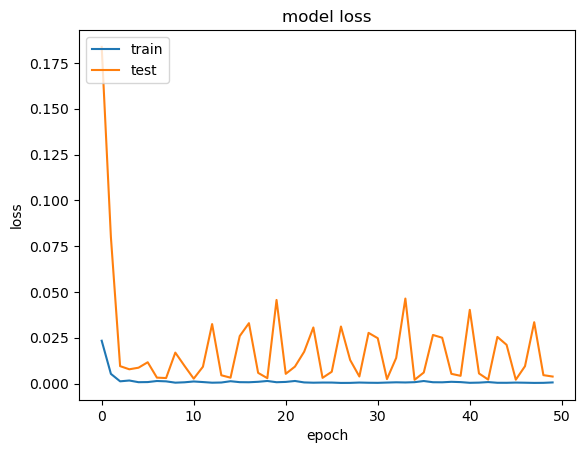

In [201]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

9/9 [==============================] - 2s 62ms/step


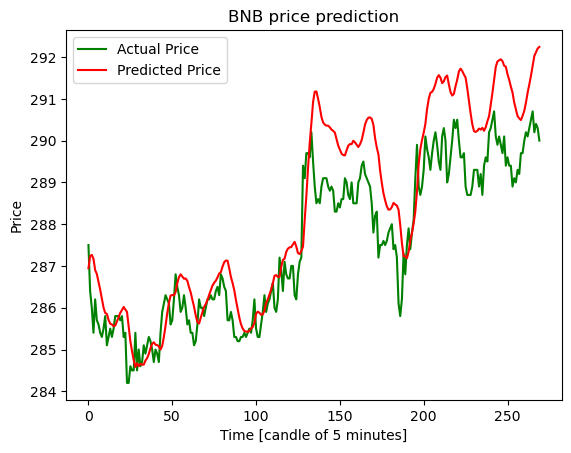

In [202]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat)
 
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('BNB price prediction')
plt.xlabel('Time [candle of 5 minutes]')
plt.ylabel('Price')
plt.legend(loc='best')
 
plt.show();

In [203]:
# Save model using the SavedModel format
!mkdir -p saved_model
model.save('saved_model/bnb-usd-prediction')

INFO:tensorflow:Assets written to: saved_model/bnb-usd-prediction/assets


INFO:tensorflow:Assets written to: saved_model/bnb-usd-prediction/assets


In [205]:
# Save model using the HDF5 format
!mkdir -p hdf5

# The '.h5' extension indicates that the model should be saved to HDF5
model.save('hdf5/bnb-usd-prediction.h5')